In [1]:
# %matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import glob
import itertools
import os

from run import Run
from runs_db import db as runs_db

[('martak', 108), ('gcp', 62), ('deepnet2', 83), ('fiit-gcp-1', 10), ('fiit-gcp-2', 13), ('fiit-gcp-3', 14), ('acer', 32)]


In [2]:
log_path = '/home/fiit/logs'
runs = []

for server in runs_db:
    paths = glob.glob(os.path.join(log_path, server, '*'))
    paths = iter(sorted(paths))

    try:
        for (number, type_, code) in runs_db[server]:
            for _ in range(number):
                try:
                    path = next(paths)
                    runs.append(Run(path, type_, code))
                except KeyError:
                    print(path)
    except StopIteration:
        pass


In [3]:
tasks = ['dep', 'lmo', 'ner', 'pos']
langs = ['cs', 'de', 'en', 'es']

task_metr = {
    'dep': 'las',
    'lmo': 'perplexity',
    'ner': 'chunk_f1',
    'pos': 'acc'
}

task_max = {
    'dep': True,
    'lmo': False,
    'ner': True,
    'pos': True
}

def draw_graphs(metric_func, tasks, langs, role, run_codes=None, run_types=None):
    fig, axes = plt.subplots(len(tasks), len(langs), figsize=(5*len(langs), 4*len(tasks)), squeeze=False)

    relevant_runs = ['vanilla']

    for task, lang in itertools.product(tasks, langs):
        for run in runs:
            if (
                run.contains(task, lang) and
                (run_codes is None or run.code in run_codes) and
                (run_types is None or run.type in run_types)
            ):

                history = run.history(
                    metric=metric_func(task),
                    task=task,
                    language=lang,
                    role=role)
                axes[tasks.index(task), langs.index(lang)].plot(list(history), label=f'{run.code}-{run.type}')

    for ax, col in zip(axes[0], langs):
        ax.set_title(col)

    for ax, row in zip(axes[:, 0], tasks):
        ax.set_ylabel(row, rotation=0, size='large')
        
    for ax_row in axes:
        for ax in ax_row:
            ax.legend()

    plt.show()
    
def print_results(metric_func, metric_max_func, tasks, langs, run_codes=None, run_types=None, print_lambda=None):
    
    if print_lambda is None:
        print_lambda = lambda val, run: print(f'{val:.2f}')
        
    output = []
    
    for task, lang in itertools.product(tasks, langs):
        for run in runs:
            if (
                run.contains(task, lang) and
                (run_codes is None or run.code in run_codes) and
                (run_types is None or run.type in run_types)
            ):
                result = run.metric_eval(
                    metric=metric_func(task),
                    max_=metric_max_func(task),
                    task=task,
                    language=lang)
                res = result[0]
                if res < 1.01:
                    res *= 100
                print_lambda(res, run)
                output.append((res, run))
                
    return output

In [4]:
print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['cs'],
     ['private-focused-0.75'], ['ml'], lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['es'],
     ['private-focused'], ['ml'], lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['ner'], ['cs'],
     ['vanilla'], ['mt'], lambda val, run: print(f'{val:.2f} {run.path}'))

print('87.69 /home/fiit/logs/acer/2019-02-22-025619')

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['pos'], ['cs'],
     ['no-adv-tsh-focused-0.75'], ['mt'], lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['pos'], ['es'],
     ['no-adv-tsh-focused'], ['mt'], lambda val, run: print(f'{val:.2f} {run.path}'))

print()

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['de'],
     ['private'], ['mt'], lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['en'],
     ['private'], ['ml'], lambda val, run: print(f'{val:.2f} {run.path}'))

print('83.07 /home/fiit/logs/deepnet2/2019-02-26-041529')
print('85.07 /home/fiit/logs/acer/2019-02-20-213852')

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['pos'], ['de'],
     ['vanilla'], ['mt'], print_lambda=lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['pos'], ['en'],
     ['private'], ['mt'], print_lambda=lambda val, run: print(f'{val:.2f} {run.path}'))

89.60 /home/fiit/logs/deepnet2/2019-02-10-081231
86.87 /home/fiit/logs/deepnet2/2019-02-08-224443
81.58 /home/fiit/logs/martak/2018-12-14-192253
87.69 /home/fiit/logs/acer/2019-02-22-025619
99.10 /home/fiit/logs/deepnet2/2019-02-27-162827
96.96 /home/fiit/logs/deepnet2/2019-02-21-180137

79.94 /home/fiit/logs/gcp/2019-02-12-112857
84.94 /home/fiit/logs/martak/2019-02-04-013803
83.07 /home/fiit/logs/deepnet2/2019-02-26-041529
85.07 /home/fiit/logs/acer/2019-02-20-213852
94.73 /home/fiit/logs/martak/2018-12-15-045335
96.16 /home/fiit/logs/gcp/2019-02-13-073702


[(96.1639622870554, <run.Run at 0x7f5634dceef0>)]

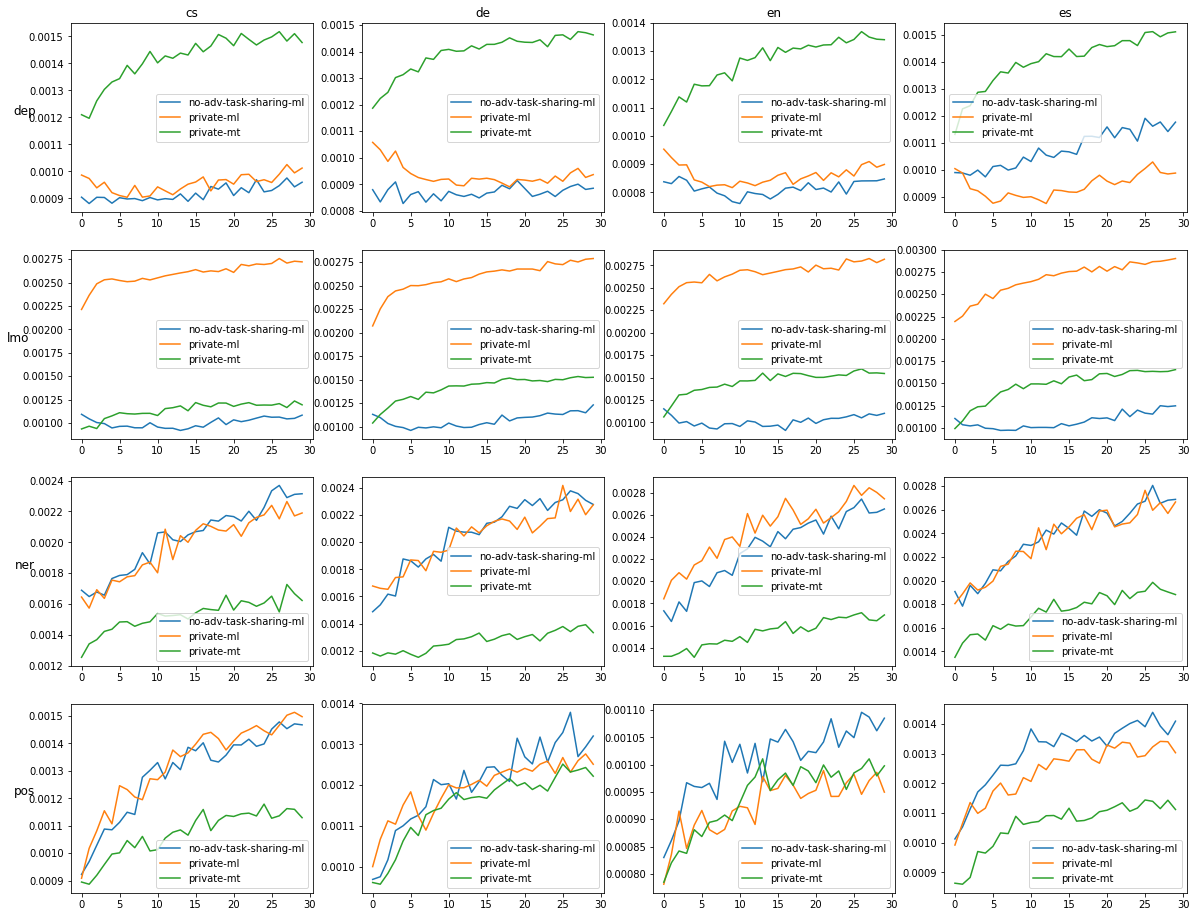

In [5]:
# draw_graphs(lambda task: task_metr[task], tasks, langs, 'test',
#              ['private-focused-200', 'no-adv-tsh-200'], ['ml'])
draw_graphs(lambda _: 'unit_strength_2', tasks, langs, 'test',
             ['private', 'no-adv-task-sharing'], ['ml', 'mt'])

In [6]:
pairs = [('dep','cs'), ('dep','es'), ('ner','cs'), ('ner','es'), ('pos','cs'), ('pos','es'),]

def print_row(code, type_):
    for t, l in pairs:
        print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                    [code], [type_], lambda val, run: print(f'{val:.2f}', end=' '))

codes = ['private-focused', 'no-adv-tsh-focused']
types = ['ml', 'mt']

print('baseline 89.16 86.51 78.10 86.77 98.89 96.46')
print('best unfocused 89.16 86.70 81.58 87.69 99.04 96.87')


for code in codes:
    for type_ in types:
        print(f'{code}{type_}', end='\t')
        print_row(code, type_)
        print()
        
codes = ['private-focused-0.75', 'no-adv-tsh-focused-0.75']
types = ['ml', 'mt']

for code in codes:
    for type_ in types:
        print(f'{code}{type_}', end='\t\t')
        print_row(code, type_)
        print()
        
codes = ['private-focused-0.75', 'no-adv-tsh-focused-0.75', 'private-focused', 'no-adv-tsh-focused']
types = ['mtml']

for code in codes:
    for type_ in types:
        print(f'{code}{type_}', end='\t\t')
        print_row(code, type_)
        print()


# print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['en'],
#             ['dep-adv-lambda-0.25'])
# print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['en'],
#             ['dep-adv-lambda-0.125'])
# print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['en'],
#             ['no-adv-task-sharing'], ['ml'])

baseline 89.16 86.51 78.10 86.77 98.89 96.46
best unfocused 89.16 86.70 81.58 87.69 99.04 96.87
private-focusedml	89.04 86.87 78.24 86.61 98.96 96.69 
private-focusedmt	88.44 86.48 77.40 86.46 99.04 96.72 
no-adv-tsh-focusedml	88.95 86.66 77.91 87.10 99.01 96.71 
no-adv-tsh-focusedmt	87.21 85.93 78.95 86.52 99.05 96.96 
private-focused-0.75ml		89.60 86.62 78.00 86.18 99.05 96.71 
private-focused-0.75mt		88.90 86.69 77.82 86.27 99.05 96.53 
no-adv-tsh-focused-0.75ml		89.47 86.60 78.06 87.35 99.00 96.65 
no-adv-tsh-focused-0.75mt		88.44 86.68 78.12 86.83 99.10 96.48 
private-focused-0.75mtml		89.39 86.57 77.45 86.79 99.04 96.75 
no-adv-tsh-focused-0.75mtml		
private-focusedmtml		
no-adv-tsh-focusedmtml		87.29 86.18 80.03 86.24 98.94 96.66 


In [7]:
import numpy as np

pairs = list(itertools.product(['dep', 'ner', 'pos'], langs))

def print_row(code, type_, msg):
    print(msg, end=' ')
    for t, l in pairs:
        print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                    [code], [type_], lambda val, run: print(f'{val:.2f}', end=' '))
    print()
        
print_row('vanilla', 'stsl', 'Baseline')

print('Best1', end=' ')
for t, l in pairs:
    output = print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                ['one-aux'], print_lambda=lambda _, __: ...)
    print(f'{max([r[0] for r in output]):.2f}', end=' ')
print()

print('Avg', end=' ')
for t, l in pairs:
    output = print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                ['one-aux'], print_lambda=lambda _, __: ...)
    print(f'{np.mean([r[0] for r in output]):.2f}', end=' ')
print()


print('Worst1', end=' ')
for t, l in pairs:
    output = print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                ['one-aux'], print_lambda=lambda _, __: ...)
    print(f'{min([r[0] for r in output]):.2f}', end=' ')
print()

print_row('vanilla', 'mt', 'A-MT')
print_row('no-adv-task-sharing', 'ml', 'A-ML')
print_row('no-adv-task-sharing', 'mtml', 'A-MTML')
print_row('private', 'mt', 'B-MT')
print_row('private', 'ml', 'B-ML')
print_row('private', 'mtml', 'B-MTML')
print_row('no-adv', 'ml', 'C-ML')
print_row('no-adv', 'mtml', 'C-MTML')

Baseline 89.16 79.93 84.92 86.51 78.10 81.36 84.96 86.77 98.89 94.19 95.99 96.46 
Best1 88.79 79.78 84.93 86.70 78.77 83.07 85.07 87.69 99.04 94.59 96.14 96.86 
Avg 88.27 79.65 84.52 86.36 78.06 82.12 84.64 86.73 98.96 94.51 96.07 96.63 
Worst1 87.39 79.57 84.02 85.83 76.91 81.83 84.38 86.22 98.93 94.43 95.99 96.33 
A-MT 84.95 78.02 83.45 84.43 81.58 81.95 84.66 86.83 98.97 94.73 95.97 96.87 
A-ML 87.35 79.79 84.75 86.34 78.23 82.07 84.67 86.98 98.75 94.46 96.14 96.57 
A-MTML 83.33 76.59 82.23 83.66 79.54 81.67 83.64 87.16 98.71 94.54 95.96 96.74 
B-MT 87.98 79.94 84.41 86.33 77.67 81.85 84.70 87.13 98.89 94.51 96.16 96.73 
B-ML 88.19 79.73 84.94 86.38 78.15 82.34 84.87 86.60 98.88 94.57 95.98 96.74 
B-MTML 87.42 79.31 84.11 85.56 78.27 82.26 84.63 86.58 98.95 94.39 95.92 96.59 
C-ML 86.06 79.34 84.57 85.96 77.02 81.15 84.24 85.96 98.65 94.28 96.10 96.51 
C-MTML 81.24 76.71 81.01 83.20 77.57 81.04 83.85 87.23 98.48 94.43 95.73 96.46 


In [8]:
for t, l in pairs:
    output = print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                ['one-aux'], print_lambda=lambda _, __: ...)
    output = sorted(output, key=lambda r: -r[0])
    print(output[0][1].hparams['tasks'])
    #print(f'{max([r[0] for r in output]):.2f}', end=' ')
print()

[('dep', 'es'), ('dep', 'cs')]
[('dep', 'cs'), ('dep', 'de')]
[('dep', 'es'), ('dep', 'en')]
[('dep', 'es'), ('dep', 'en')]
[('dep', 'cs'), ('ner', 'cs')]
[('ner', 'de'), ('lmo', 'de')]
[('ner', 'cs'), ('ner', 'en')]
[('ner', 'es'), ('lmo', 'es')]
[('dep', 'cs'), ('pos', 'cs')]
[('ner', 'de'), ('pos', 'de')]
[('pos', 'en'), ('lmo', 'en')]
[('pos', 'es'), ('pos', 'en')]



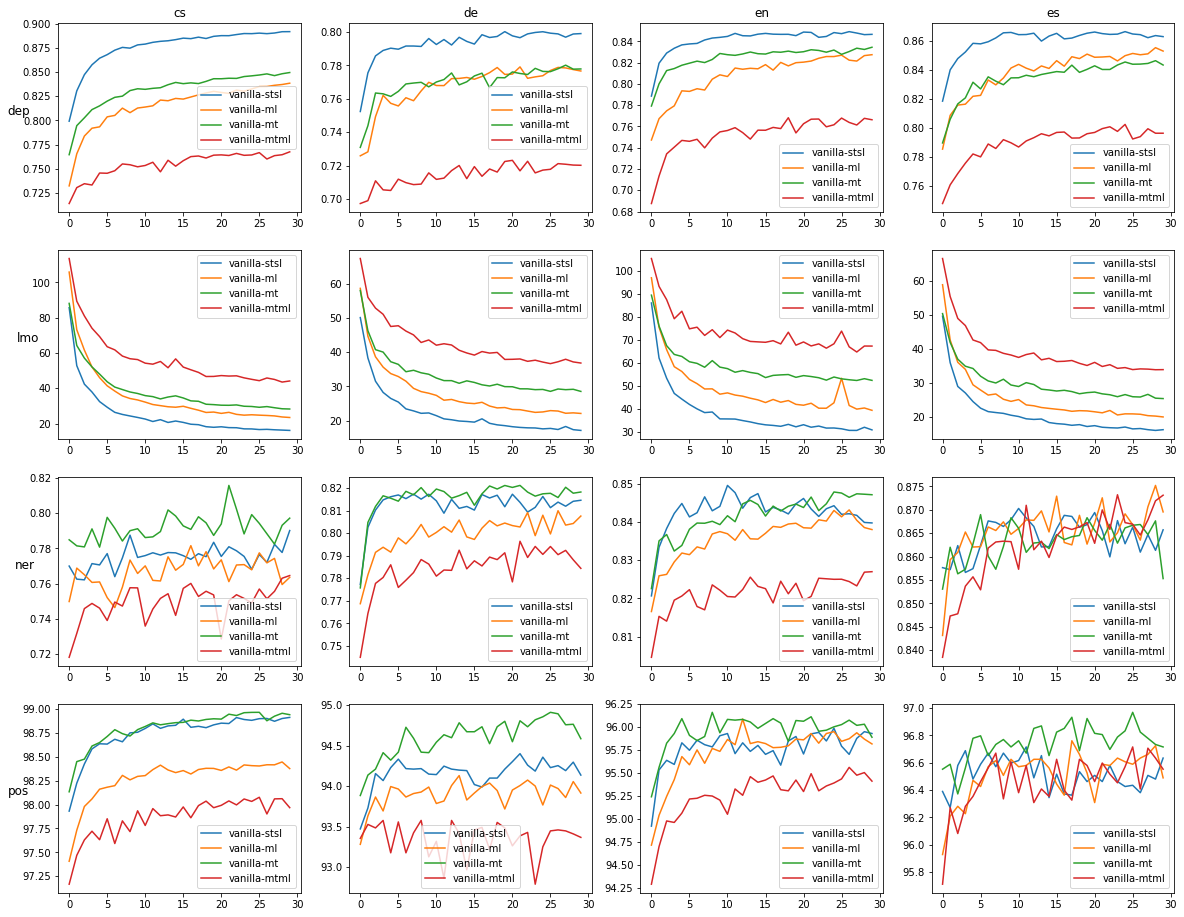

In [9]:
draw_graphs(lambda task: task_metr[task], tasks, langs, 'test', ['vanilla'])

In [10]:
print_results(lambda task: task_metr[task], lambda task: task_max[task], tasks, langs,
     ['fine-tune'], print_lambda=lambda val, run: print(f'{val:.2f} {run.hparams["train_only"]}'))

89.69 dep-cs
80.24 dep-de
85.25 dep-en
86.77 dep-es
79.11 ner-cs
82.64 ner-de
99.08 pos-cs
96.05 pos-en
96.73 pos-es


[(89.6894316384639, <run.Run at 0x7f5632ef5518>),
 (80.24357239512855, <run.Run at 0x7f563533b898>),
 (85.25472423420871, <run.Run at 0x7f56383154e0>),
 (86.772821858319, <run.Run at 0x7f5633bc3898>),
 (79.11145752143415, <run.Run at 0x7f5636179e80>),
 (82.63649778652238, <run.Run at 0x7f563568efd0>),
 (99.07599974510337, <run.Run at 0x7f5633cd5198>),
 (96.05066159511189, <run.Run at 0x7f5634f18e10>),
 (96.73391839319642, <run.Run at 0x7f5634465ac8>)]

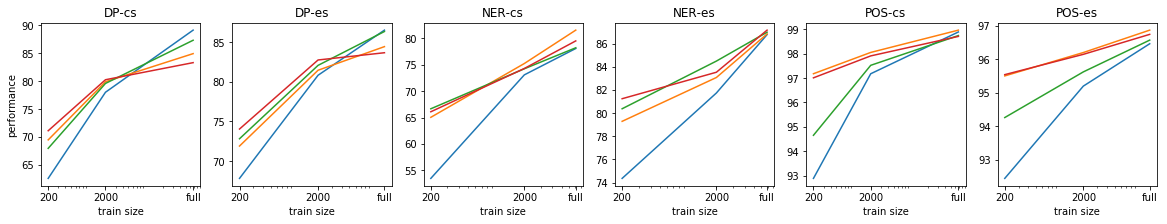

In [11]:
def yield_results(task, lang):
    
    code_types = [
        ('vanilla-200', 'stsl'),
        ('vanilla-2000', 'stsl'),
        ('vanilla', 'stsl'),
        ('no-adv-tsh-200', 'mt'),
        ('no-adv-tsh-2000', 'mt'),
        ('vanilla', 'mt'),
        ('no-adv-tsh-200', 'ml'),
        ('no-adv-tsh-2000', 'ml'),
        ('no-adv-task-sharing', 'ml'),
        ('no-adv-tsh-200', 'mtml'),
        ('no-adv-tsh-2000', 'mtml'),
        ('no-adv-task-sharing', 'mtml'),

        
    ]
    
    for code, type_ in code_types:

        output = print_results(lambda task: task_metr[task], lambda task: task_max[task], [task], [lang],
         [code], [type_], print_lambda=lambda val, run: ...)
        for res, run in output:
            if run.hparams['limited_task_language'] in [f'{task}-{lang}', None]:
                yield res

fig, axes = plt.subplots(1, 6, figsize=(20, 3), squeeze=False)

sizes = {
    ('dep', 'cs'): 67900,
    ('dep', 'es'): 14000,
    ('ner', 'cs'): 7100,
    ('ner', 'es'): 6900, 
    ('pos', 'cs'): 67900,  
    ('pos', 'es'): 14000,
}

titles = {
    ('dep', 'cs'): 'DP-cs',
    ('dep', 'es'): 'DP-es',
    ('ner', 'cs'): 'NER-cs',
    ('ner', 'es'): 'NER-es', 
    ('pos', 'cs'): 'POS-cs',  
    ('pos', 'es'): 'POS-es',    
}

for i, (t, l) in enumerate(itertools.product(['dep', 'ner', 'pos'], ['cs', 'es'])):
    results = list(yield_results(t, l))
    axes[0, i].plot([200,2000,sizes[t, l]], results[0:3])
    axes[0, i].plot([200,2000,sizes[t, l]], results[3:6])
    axes[0, i].plot([200,2000,sizes[t, l]], results[6:9])  
    axes[0, i].plot([200,2000,sizes[t, l]], results[9:12])
    axes[0, i].set_xscale('log')
    axes[0, i].set_xticks([200,2000,sizes[t, l]])
    axes[0, i].set_xticklabels(['200', '2000', 'full'])
    axes[0, i].set_title(titles[t, l])
    axes[0, i].set_xlabel('train size')

    
axes[0,0].set_ylabel('performance')
    

#           ax.set_title(col)

#     for ax, row in zip(axes[:, 0], tasks):
#         ax.set_ylabel(row, rotation=0, size='large')
        
#     for ax_row in axes:
#         for ax in ax_row:
#             ax.legend()
  

# for ax, col in zip(axes[0], langs):
#     ax.set_title(col)

# for ax, row in zip(axes[:, 0], tasks):
#     ax.set_ylabel(row, rotation=0, size='large')

# for ax_row in axes:
#     for ax in ax_row:
#         ax.legend()

plt.savefig('sample.pdf')
plt.show()



